In [114]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import math
import mediapipe as mp
import pandas as pd


# Initial Pose Detection

In [115]:
plt.rcParams["figure.figsize"] = (20, 20)

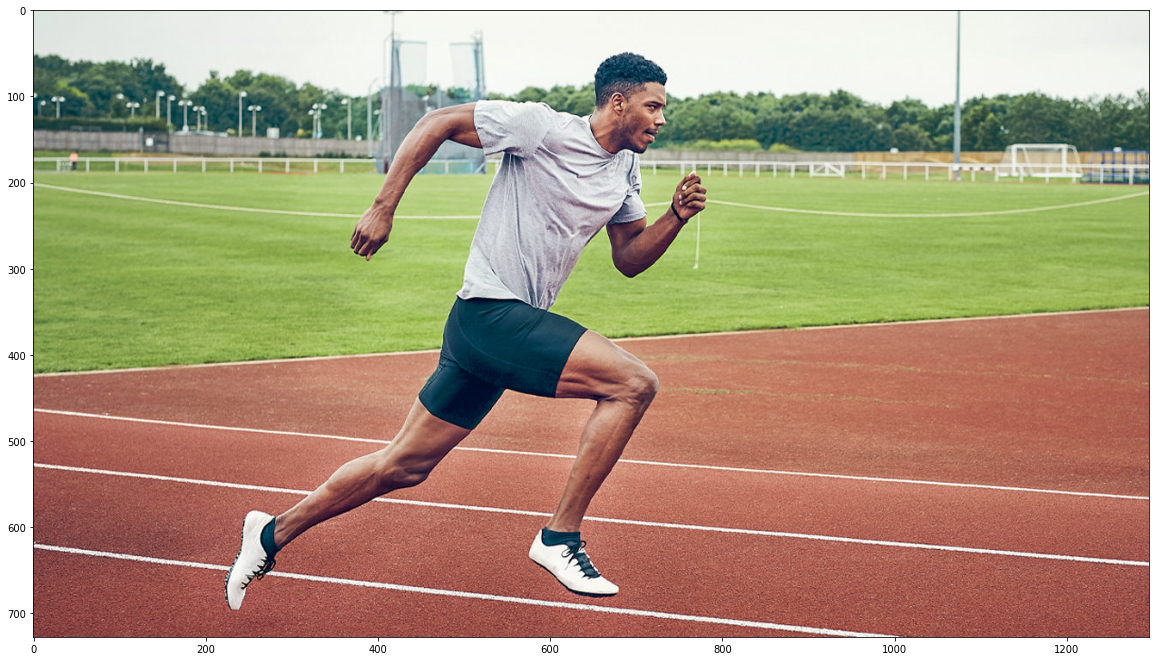

In [116]:
image = cv.imread('./inputs/run_0.jpg')
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
plt.imshow(image)

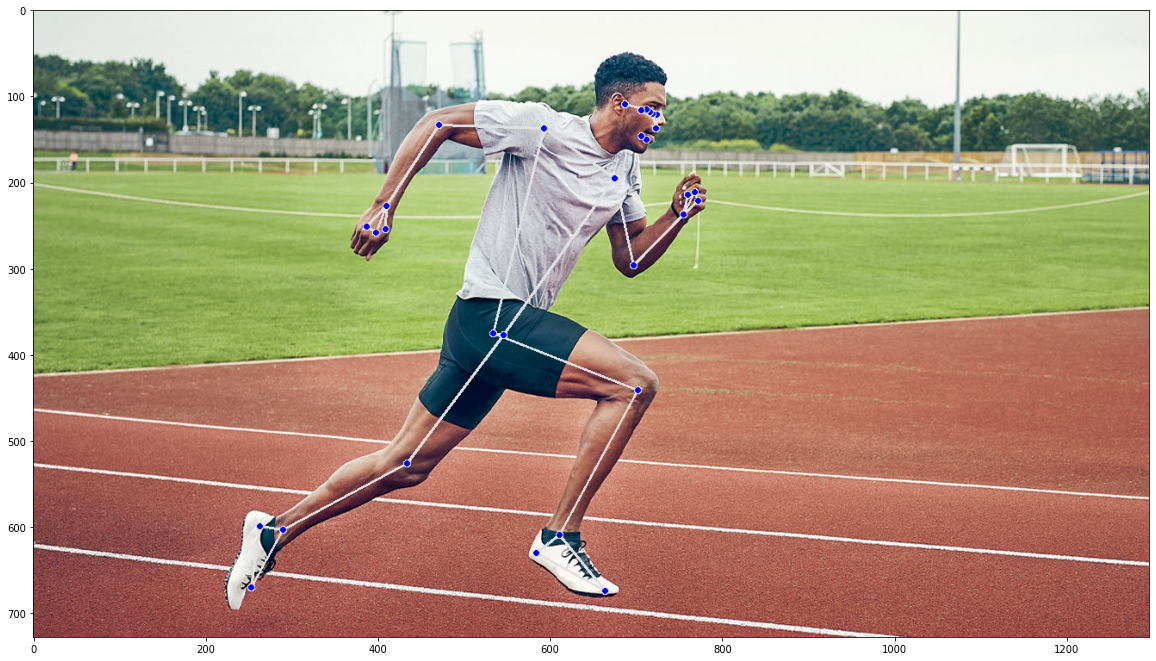

In [117]:
pose_sol = mp.solutions.pose
draw_utils = mp.solutions.drawing_utils
pose = pose_sol.Pose()

results = pose.process(image)
image_clone = image.copy()
draw_utils.draw_landmarks(image_clone, results.pose_landmarks, pose_sol.POSE_CONNECTIONS)
plt.imshow(image_clone)

# Labelling

In [118]:
# converts to image coordinates
landmark_names = ["nose", "left_eye_inner", "left_eye", "left_eye_outer", "right_eye_inner", "right_eye", "right_eye_outer", "left_ear", "right_ear", "mouth_left", "mouth_right", "left_shoulder", "right_shoulder", "left_elbow", "right_elbow", "left_wrist", "right_wrist", "left_pinky", "right_pinky", "left_index", "right_index", "left_thumb", "right_thumb", "left_hip", "right_hip", "left_knee", "right_knee", "left_ankle", "right_ankle", "left_heel", "right_heel", "left_foot_index", "right_foot_index"]

def label_landmarks():
    landmarks = {}
    for index, name in enumerate(landmark_names):
        landmarks[name] = {'id' : index}

    for id, landmark in enumerate(results.pose_landmarks.landmark):
        height, width, channel = image.shape
        cx, cy = int(landmark.x * width), int(landmark.y * height)
        landmarks[landmark_names[id]]["image_coords"] = (cx, cy)

    for id, landmark in enumerate(results.pose_world_landmarks.landmark):
        x, y, z = landmark.x, landmark.y, landmark.z
        landmarks[landmark_names[id]]["world_coords"] = (x, y, z)

    landmarks_df = pd.DataFrame(landmarks).T
    return landmarks_df

landmarks_df = label_landmarks()
landmarks_df.head()

id image_coords  \
nose             0   (723, 137)   
left_eye_inner   1   (725, 122)   
left_eye         2   (725, 121)   
left_eye_outer   3   (724, 121)   
right_eye_inner  4   (719, 120)   

                                                      world_coords  
nose             (0.39167237281799316, -0.444375216960907, -0.0...  
left_eye_inner   (0.3937892019748688, -0.49007827043533325, -0....  
left_eye         (0.3941047489643097, -0.49005553126335144, -0....  
left_eye_outer   (0.3941686749458313, -0.4910150170326233, -0.0...  
right_eye_inner  (0.37828564643859863, -0.4921993315219879, -0....

In [119]:
limb_names = {(12,14):"right_arm", (14,16):"right_forearm", (11,13):"left_arm", (13,15):"left_forearm", (23,25):"left_leg", (25,27):"left_calf", (24,26):"right_leg", 
              (26,28):"right_calf", (29,31): "left_sole", (30,32): "right_sole", (28,32): "right_forefoot", (27,31): "left_forefoot", (11,23): "left_torso", (12,24): "right_torso",
              (11,12): "shoulders", (23,24): "hips"}

def create_limbs():
    limbs = {}
    for tuple in pose_sol.POSE_CONNECTIONS:
        if tuple in limb_names.keys():
            first_node = tuple[0]
            second_node = tuple[1]
            first_node = landmarks_df.loc[landmarks_df['id'] == first_node].iloc[0]
            second_node = landmarks_df.loc[landmarks_df['id'] == second_node].iloc[0]
            name = limb_names[tuple]
            # vector
            vector = np.array(second_node["image_coords"]) - np.array(first_node["image_coords"])
            limbs[name] = {"vector": vector, "first_node": first_node, "second_node": second_node}
    return limbs
limbs = create_limbs()

In [120]:
def get_gradient(point_0, point_1):
    # y1 - y0 / x1 - x0
    return (point_1[1] - point_0[1]) / (point_1[0] - point_0[0])

def get_angle(limb_0, limb_1):
    if limb_0 in limbs.keys() and limb_1 in limbs.keys():
        limb_0_0 = limbs[limb_0]["first_node"]["image_coords"]
        limb_0_1 = limbs[limb_0]["second_node"]["image_coords"]
        limb_1_0 = limbs[limb_1]["first_node"]["image_coords"]
        limb_1_1 = limbs[limb_1]["second_node"]["image_coords"]

        if limb_0_0 == limb_1_0:
            a = limb_0_1
            b = limb_1_1
            common = limb_0_0
        elif limb_0_0 == limb_1_1:
            a = limb_0_1
            b = limb_1_0
            common = limb_0_0
        elif limb_0_1 == limb_1_0:
            a = limb_0_0
            b = limb_1_1
            common = limb_0_1
        elif limb_0_1 == limb_1_1:
            a = limb_0_0
            b = limb_1_0
            common = limb_0_1
        else:
            return None

        m0 = get_gradient(a, common)
        m1 = get_gradient(b, common)
        angle_rad = math.atan((m1 - m0) / (1 + m0 * m1))
        angle_deg = (math.degrees(angle_rad))
        angle_deg = angle_deg if angle_deg > 0 else 180 + angle_deg

        return angle_deg
    else:
        return None

def get_vector(limb):
    if limb in limbs.keys():
        return limbs[limb]["vector"]
    else:
        return None

In [121]:
def label_limbs(image):
    for limb in limbs.keys():
        first_node = limbs[limb]["first_node"]
        second_node = limbs[limb]["second_node"]
        x = (first_node["image_coords"][0] + second_node["image_coords"][0]) / 2
        y = (first_node["image_coords"][1] + second_node["image_coords"][1]) / 2
        cv.putText(image, limb, (int(x) - 20, int(y) - 20), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv.LINE_AA)

In [122]:
valid_angles = ['right_arm|right_forearm', 'left_arm|left_forearm', 
                'right_calf|right_leg', 'left_calf|left_leg', 
                'right_calf|right_forefoot', 'left_calf|left_forefoot', 
                'right_arm|right_torso', 'left_arm|left_torso',
                'right_leg|right_torso', 'left_leg|left_torso']
                
def label_angles(image):
    for index, angle in enumerate(valid_angles):
        limb_0, limb_1 = angle.split("|")
        limb_0_0 = limbs[limb_0]["first_node"]
        limb_0_1 = limbs[limb_0]["second_node"]
        limb_1_0 = limbs[limb_1]["first_node"]
        limb_1_1 = limbs[limb_1]["second_node"]
        # find the common node
        if limb_0_0["id"] == limb_1_0["id"]:
            common_node = limb_0_0
        elif limb_0_0["id"] == limb_1_1["id"]:
            common_node = limb_0_0
        elif limb_0_1["id"] == limb_1_0["id"]:
            common_node = limb_0_1
        elif limb_0_1["id"] == limb_1_1["id"]:
            common_node = limb_0_1
        else:
            continue
        angle = get_angle(limb_0, limb_1)
        x = common_node["image_coords"][0]
        y = common_node["image_coords"][1]
        cv.putText(image, str(round(angle, 1)), (int(x) + 20, int(y) + 20), cv.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1, cv.LINE_AA)

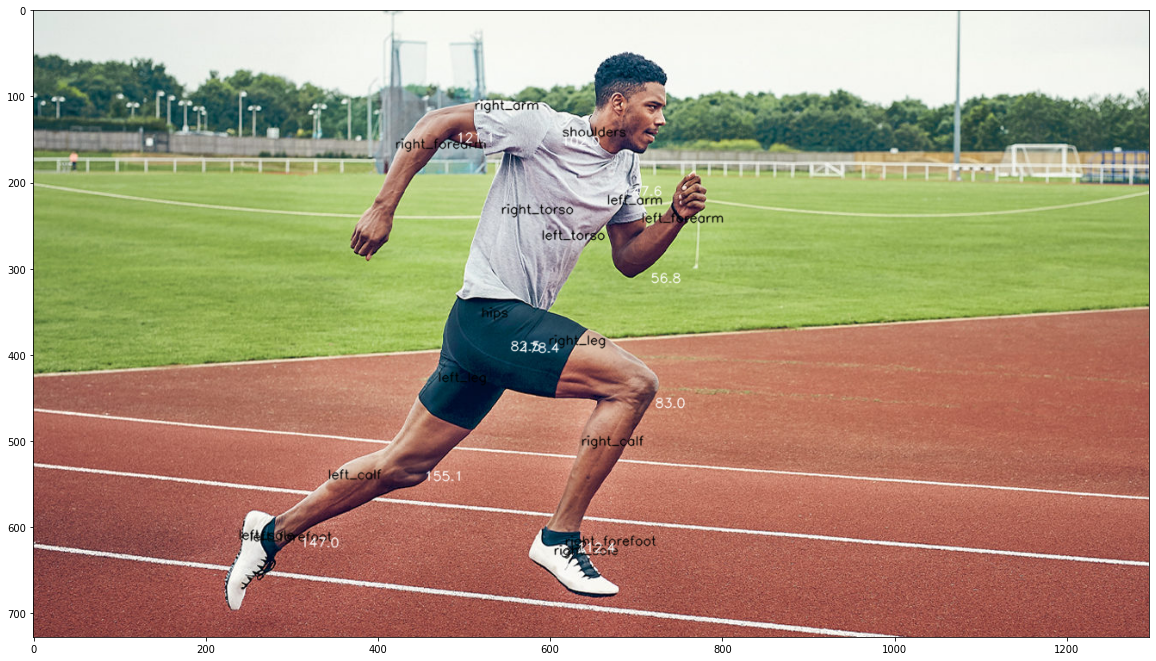

In [123]:
labelled_image = image.copy()
label_limbs(labelled_image)
label_angles(labelled_image)
plt.imshow(labelled_image)

# Different Photo

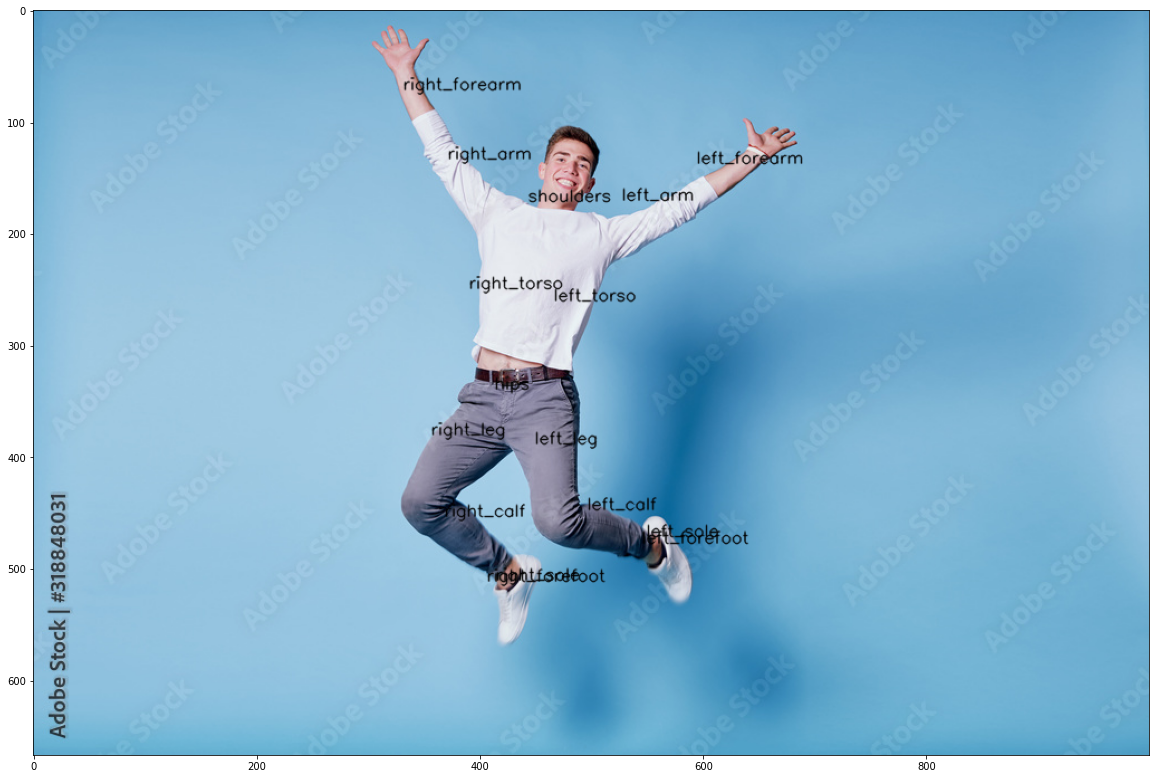

In [138]:
from classes import pose_detector
running_image = image.copy()
running = pose_detector.process_image(running_image)
running.create_landmarks()
running.create_limbs()
test = running.label_limbs()
plt.imshow(test)